In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib


In [67]:
data = pd.read_csv("../data/data.csv")
data.head()

,age,gender,status,pressurehight,pressurelow,glucose,kcm,troponin,impluse
0,64,1,negative,160,83,160.0,1.80,0.012,66
1,21,1,positive,98,46,296.0,6.75,1.060,94
2,55,1,negative,160,77,270.0,1.99,0.003,64
3,64,1,positive,120,55,270.0,13.87,0.122,70
4,55,1,negative,112,65,300.0,1.08,0.003,64


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1319 non-null   int64  
 1   gender         1319 non-null   int64  
 2   status         1319 non-null   object 
 3   pressurehight  1319 non-null   int64  
 4   pressurelow    1319 non-null   int64  
 5   glucose        1319 non-null   float64
 6   kcm            1319 non-null   float64
 7   troponin       1319 non-null   float64
 8   impluse        1319 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [69]:
data.describe()

,age,gender,pressurehight,pressurelow,glucose,kcm,troponin,impluse
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,127.170584,72.269143,146.634344,15.274306,0.360942,78.336619
std,13.647315,0.474027,26.122720,14.033924,74.923045,46.327083,1.154568,51.630270
min,14.000000,0.000000,42.000000,38.000000,35.000000,0.321000,0.001000,20.000000
25%,47.000000,0.000000,110.000000,62.000000,98.000000,1.655000,0.006000,64.000000
50%,58.000000,1.000000,124.000000,72.000000,116.000000,2.850000,0.014000,74.000000
75%,65.000000,1.000000,143.000000,81.000000,169.500000,5.805000,0.085500,85.000000
max,103.000000,1.000000,223.000000,154.000000,541.000000,300.000000,10.300000,1111.000000


In [70]:
data.isnull().sum()

age              0
gender           0
status           0
pressurehight    0
pressurelow      0
glucose          0
kcm              0
troponin         0
impluse          0
dtype: int64

In [71]:
data.duplicated().sum()

np.int64(0)

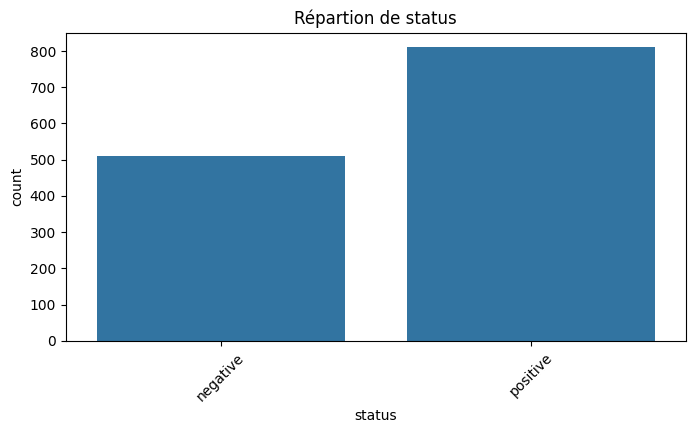

In [72]:
def count_plot(data,column):
    plt.figure(figsize=(8,4))
    sns.countplot(x=column, data=data, hue=None)
    plt.title("Répartion de "+column)
    plt.xticks(rotation=45)
    plt.show()


count_plot(data,column='status')

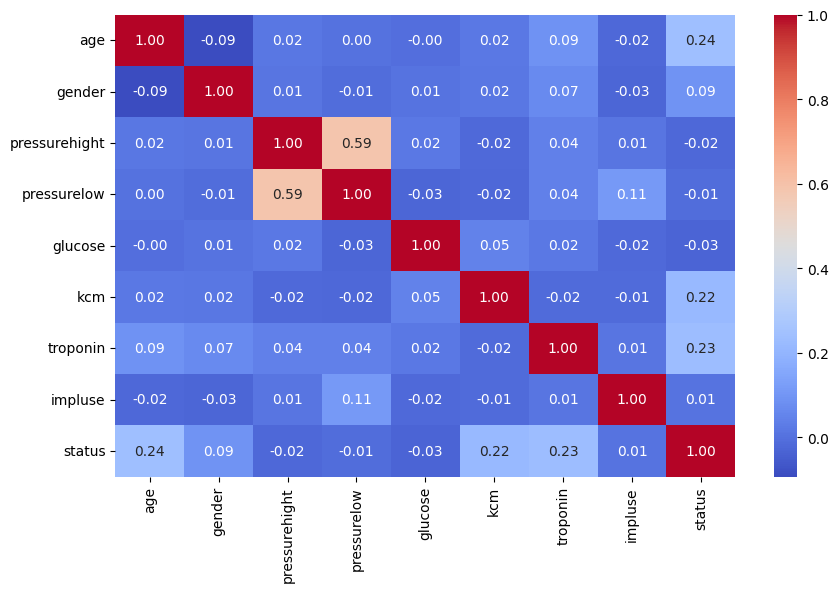

In [73]:
def correlation(data,clmn):
    columns_to_encoder = data.select_dtypes(include=['int64','float64'])
    columns_to_encoder[clmn] = data[clmn].map(lambda x: 0 if x == "negative" else 1)
    corr = columns_to_encoder.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr,annot=True,cmap="coolwarm",fmt=".2f")
    plt.show()
    

correlation(data,'status')

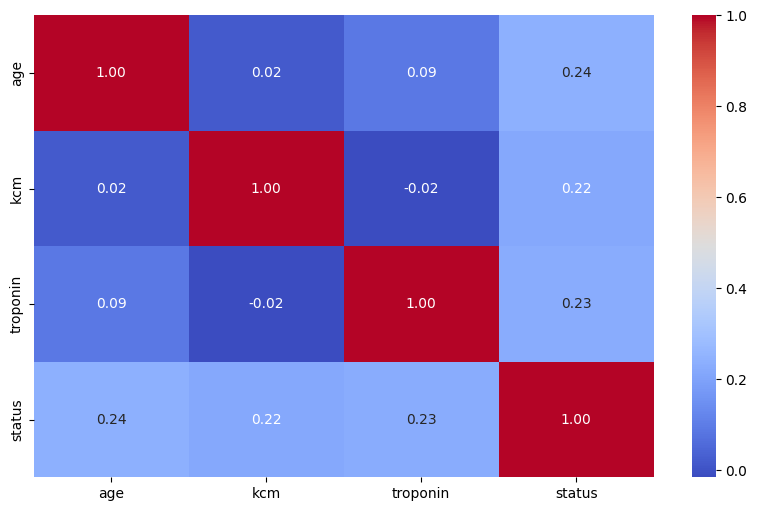

In [74]:
def correlation(data,clmn):
    columns_to_encoder = data.select_dtypes(include=['int64','float64']).drop(columns=['impluse', 'glucose', 'pressurelow', 'pressurehight', 'gender'])
    columns_to_encoder[clmn] = data[clmn].map(lambda x: 0 if x == "negative" else 1)
    corr = columns_to_encoder.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr,annot=True,cmap="coolwarm",fmt=".2f")
    plt.show()
    

correlation(data,'status')

In [76]:
from ML import *

def encoder_cible(data, cible):
    data[cible] = data[cible].map(lambda x: 0 if x == "negative" else 1)
    return data


data = encoder_cible(data, 'status')
data.head()

,age,gender,status,pressurehight,pressurelow,glucose,kcm,troponin,impluse
0,64,1,0,160,83,160.0,1.80,0.012,66
1,21,1,1,98,46,296.0,6.75,1.060,94
2,55,1,0,160,77,270.0,1.99,0.003,64
3,64,1,1,120,55,270.0,13.87,0.122,70
4,55,1,0,112,65,300.0,1.08,0.003,64


In [77]:
def split_data(data, cible):
    X = data.drop(columns=[cible]) 
    y = data[cible]
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data, 'status')
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((923, 8), (396, 8), (923,), (396,))

In [ ]:

X_num = ['age','pressurehight','pressurelow','glucose','kcm','troponin','impluse']

def train_model_with_grid(X_train, y_train, X_num, model_type='rf'):
    # --- Prétraitement ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X_num)
        ]
    )

    # --- Choix du modèle et param_grid ---
    if model_type == 'rf':
        model = RandomForestClassifier(random_state=42, class_weight='balanced')
        param_grid = {
            'feature_selection__k': [5, 8, 10],
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    elif model_type == 'xgb':
        model = XGBClassifier(random_state=42)
        param_grid = {
            'feature_selection__k': [5, 8, 10],
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2]
        }
    else:
        raise ValueError("model_type doit être 'rf' ou 'xgb'")

    # --- Pipeline ---
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('classifier', model)
    ])

    # --- GridSearchCV ---
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',  # pour classification
        n_jobs=-1
    )

    # --- Entraînement ---
    grid_search.fit(X_train, y_train)

    return grid_search




In [79]:
grid_rf = train_model_with_grid(X_train, y_train, X_num, model_type='rf')
grid_xgb = train_model_with_grid(X_train, y_train, X_num, model_type='xgb')

c:\Users\asus\OneDrive\Bureau\Cardio_Risk_Prediction\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=8 is greater than n_features=7. All the features will be returned.
  warnings.warn(


In [80]:
print("Meilleurs paramètres RandomForest :")
print(grid_rf.best_params_)

print("\nMeilleurs paramètres XGBOOSt :")
print(grid_xgb.best_params_)

Meilleurs paramètres RandomForest :
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'feature_selection__k': 8}

Meilleurs paramètres XGBOOSt :
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'feature_selection__k': 5}


In [81]:
def evaluate_model(grid, X_test, y_test):
    # Prédiction
    y_pred = grid.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy : {acc:.2f}")
    print(f"F1-score : {f1:.2f}\n")
    print("Classification Report :")
    print(classification_report(y_test, y_pred))
    
    return y_pred


In [82]:
print("Performance RandomForest :")
y_pred_rf = evaluate_model(grid_rf, X_test, y_test)

print("\nPerformance XGBOOST :")
y_pred_xg = evaluate_model(grid_xgb, X_test, y_test)

Performance RandomForest :
Accuracy : 0.98
F1-score : 0.98

Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       155
           1       0.98      0.98      0.98       241

    accuracy                           0.98       396
   macro avg       0.98      0.98      0.98       396
weighted avg       0.98      0.98      0.98       396


Performance XGBOOST :
Accuracy : 0.98
F1-score : 0.98

Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       155
           1       0.98      0.98      0.98       241

    accuracy                           0.98       396
   macro avg       0.98      0.98      0.98       396
weighted avg       0.98      0.98      0.98       396



In [83]:
import joblib

# Sauvegarder le meilleur modèle
joblib.dump(grid_rf.best_estimator_, 'best_model_rf.pkl')
joblib.dump(grid_xgb.best_estimator_, 'best_model_xgb.pkl')

print("Modèles sauvegardés avec succès ✅")


Modèles sauvegardés avec succès ✅
